In [1]:
import numpy as np
from models import RegressionTree

### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Для увеличения скорости построения моделей используется DecisionTreeRegressor из sklearn

In [2]:
from sklearn.tree import DecisionTreeRegressor

In [3]:
class GBRegressor:
    
    def __init__(self, max_depth=1, n_trees=100, eta=0.1, subsample_size=None):
        self.max_depth = max_depth
        self.n_trees = n_trees
        self.eta = eta
        self.subsample_size = subsample_size
    
    def _residuals(self, y, z):
        return - (z - y)
    
    def _get_indices(self, n):
        '''Возвращает индексы объектов обучающей подвыборки.'''
        shuffled = np.random.permutation(n)
        indices = shuffled[:int(self.subsample_size * n)]
        return indices
    
    def predict(self, X):

        prediction = np.zeros(X.shape[0])
        for alg in self.trees_list:
            prediction += self.eta * alg.predict(X)
            
        return prediction
    
    def fit(self, X, y):
        self.trees_list = []
        for _ in range(self.n_trees):
#             tree = RegressionTree(max_depth=self.max_depth)
            # для ускорения работы модели используется дерево из sklearn
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            
            data = X
            target = y
            
            # проверка: если задан размер обучающей подвыборки, 
            # то из исходной выборки отбирается подвыборка из случайных объектов
            if self.subsample_size is not None:
                # индексы объектов подвыборки
                indices = self._get_indices(data.shape[0])
                
                # подвыборка, участвующая в обучении
                data = data[indices]
                target = target[indices]
            
            if not self.trees_list:
                tree.fit(data, target)
                
            else:
                pred_target = self.predict(data)    
                tree.fit(data, self._residuals(target, pred_target))
                
            self.trees_list.append(tree)
            
        return self

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from matplotlib import pyplot as plt, ticker

In [5]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Функция для нахождения среднеквадратичной ошибки

In [7]:
def mse(y, y_pred):
    return np.mean((y - y_pred)**2)

Функция для построения графика

In [8]:
def get_error_plot(dots, train_err, test_err, title, x_label, major_segment, minor_segment):
    fig, ax = plt.subplots()

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('MSE')

    ax.plot(dots, train_mse, label='train error')
    ax.plot(dots, test_mse, label='test error')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_segment))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_segment))

    ax.legend(loc='upper right')

    fig.set_figheight(8)
    fig.set_figwidth(13)

In [9]:
%%time
n_trees_list = list(range(1, 101))

train_mse = []
test_mse = []

for n_trees in n_trees_list:
    model = GBRegressor(n_trees=n_trees, max_depth=3)
    model.fit(X_train, y_train)
    
    train_mse.append(mse(y_train, model.predict(X_train)))
    test_mse.append(mse(y_test, model.predict(X_test)))
    
print(f'Минимальная ошибка на тренировочной выборке: {min(train_mse):.2f}')
print(f'Минимальная ошибка на тестовой выборке: {min(test_mse):.2f}')

Минимальная ошибка на тренировочной выборке: 905.45
Минимальная ошибка на тестовой выборке: 2980.04
CPU times: user 16.7 s, sys: 7.38 ms, total: 16.8 s
Wall time: 16.8 s


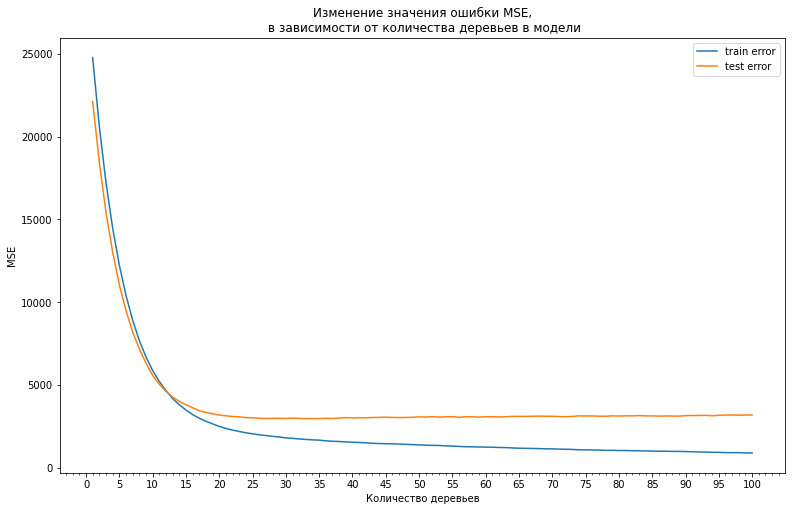

In [10]:
title = 'Изменение значения ошибки MSE,\n в зависимости от количества деревьев в модели'
x_label = 'Количество деревьев'
major_segment = 5
minor_segment = 1

get_error_plot(n_trees_list, train_mse, test_mse, title, x_label, major_segment, minor_segment)

По мере увеличения количества деревьев в модели, ошибка падает и на тренировочной и на тестовой выборке. При количестве деревьев больше 15-ти (глубина деревьев 3), модель показывает признаки переобучения. На тренировочной выборке ошибка продолжает падать, а на тестовой постепенно повышаться.

In [11]:
%%time
max_depth_list = list(range(1, 11))

train_mse = []
test_mse = []

for max_depth in max_depth_list:
    model = GBRegressor(max_depth=max_depth, n_trees=15)
    model.fit(X_train, y_train)
    
    train_mse.append(mse(y_train, model.predict(X_train)))
    test_mse.append(mse(y_test, model.predict(X_test)))
    
print(f'Минимальная ошибка на тренировочной выборке: {min(train_mse):.2f}')
print(f'Минимальная ошибка на тестовой выборке: {min(test_mse):.2f}')

Минимальная ошибка на тренировочной выборке: 1308.64
Минимальная ошибка на тестовой выборке: 3740.84
CPU times: user 257 ms, sys: 50 µs, total: 257 ms
Wall time: 256 ms


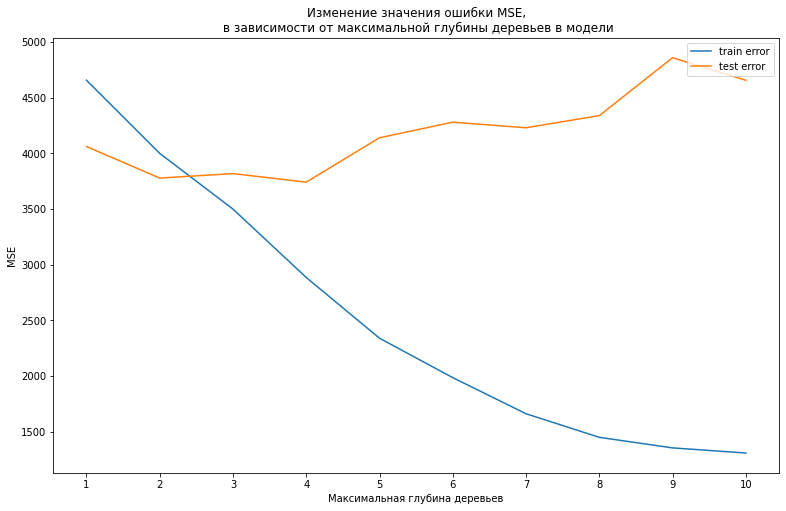

In [12]:
title = 'Изменение значения ошибки MSE,\n в зависимости от максимальной глубины деревьев в модели'
x_label = 'Максимальная глубина деревьев'
major_segment = 1
minor_segment = 1

get_error_plot(max_depth_list, train_mse, test_mse, title, x_label, major_segment, minor_segment)

При увеличении глубины деревьев ошибка сильно падает на тренировочной выборке. На тестовой почти сразу начинает повышаться. Это говорит о том, что градиентный бустинг наилучшим образом показывает себя, если включает в себя ряд простых моделей (деревьев небольшой глубины).

Попробуем обучить деревья с глубиной 1.

In [13]:
%%time
n_trees_list = list(range(1, 101))

train_mse = []
test_mse = []

for n_trees in n_trees_list:
    model = GBRegressor(n_trees=n_trees, max_depth=1)
    model.fit(X_train, y_train)
    
    train_mse.append(mse(y_train, model.predict(X_train)))
    test_mse.append(mse(y_test, model.predict(X_test)))
    
print(f'Минимальная ошибка на тренировочной выборке: {min(train_mse):.2f}')
print(f'Минимальная ошибка на тестовой выборке: {min(test_mse):.2f}')

Минимальная ошибка на тренировочной выборке: 2495.01
Минимальная ошибка на тестовой выборке: 2776.94
CPU times: user 14.3 s, sys: 19.6 ms, total: 14.3 s
Wall time: 14.3 s


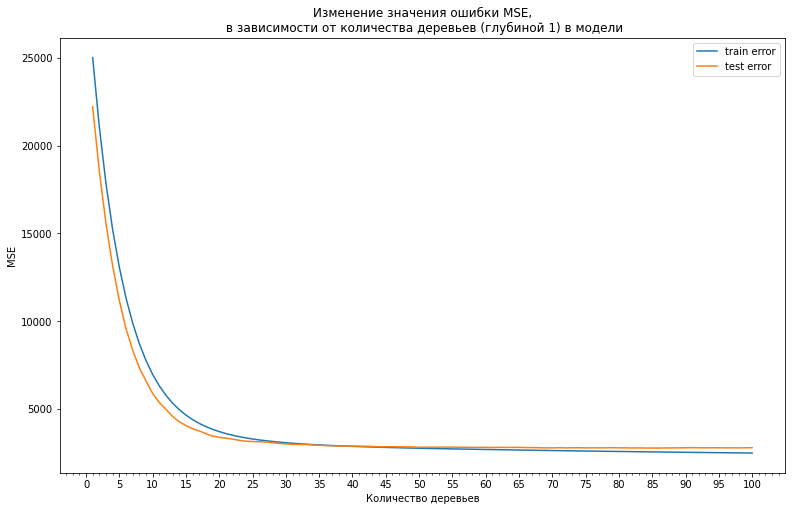

In [14]:
title = 'Изменение значения ошибки MSE,\n в зависимости от количества деревьев (глубиной 1) в модели'
x_label = 'Количество деревьев'
major_segment = 5
minor_segment = 1

get_error_plot(n_trees_list, train_mse, test_mse, title, x_label, major_segment, minor_segment)

Градиентный бустинг показывает себя наилучшим образом, если включает в себя простые модели (неглубокие деревья)

### 2. * Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

Реализовано внутри класса GBRegressor, инициируется передачей аргумента в subsample_size, как доля объектов от основной выборки

Для визуализации построим графики

In [15]:
%%time
n_trees_list = list(range(1, 101))

train_mse = []
test_mse = []

for n_trees in n_trees_list:
    model = GBRegressor(n_trees=n_trees, max_depth=1, subsample_size=0.5)
    model.fit(X_train, y_train)
    
    train_mse.append(mse(y_train, model.predict(X_train)))
    test_mse.append(mse(y_test, model.predict(X_test)))

CPU times: user 13.6 s, sys: 7.83 ms, total: 13.6 s
Wall time: 13.7 s


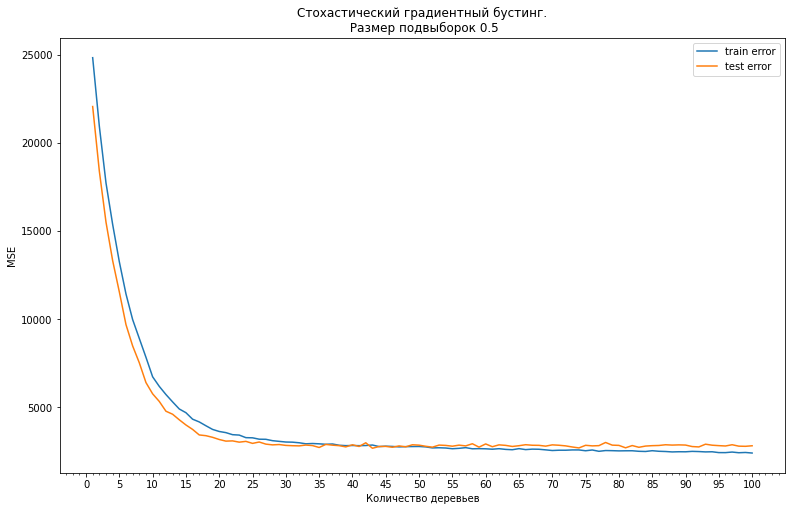

In [16]:
title = 'Стохастический градиентный бустинг.\n Размер подвыборок 0.5'
x_label = 'Количество деревьев'
major_segment = 5
minor_segment = 1

get_error_plot(n_trees_list, train_mse, test_mse, title, x_label, major_segment, minor_segment)

In [17]:
%%time
n_trees_list = list(range(1, 101))

train_mse = []
test_mse = []

for n_trees in n_trees_list:
    model = GBRegressor(n_trees=n_trees, max_depth=1, subsample_size=0.2)
    model.fit(X_train, y_train)
    
    train_mse.append(mse(y_train, model.predict(X_train)))
    test_mse.append(mse(y_test, model.predict(X_test)))

CPU times: user 12.4 s, sys: 8.08 ms, total: 12.4 s
Wall time: 12.4 s


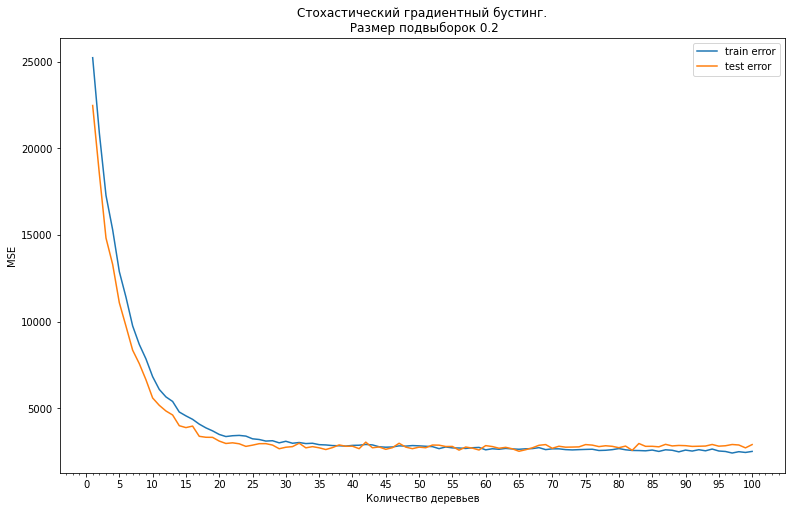

In [18]:
title = 'Стохастический градиентный бустинг.\n Размер подвыборок 0.2'
x_label = 'Количество деревьев'
major_segment = 5
minor_segment = 1

get_error_plot(n_trees_list, train_mse, test_mse, title, x_label, major_segment, minor_segment)